In [1]:
from classiq import *
import numpy as np
import math

In [2]:
t = 2
k = 3
x0 = [1, 1]
M = [[0, 1], [-1, 0]]

def C(m):
   return 2 ** ((m + 1) / 2) * t ** m / math.factorial(m)

T = math.ceil(math.log2(k+1))
N = math.sqrt(sum([C(i) for i in range(k+1)]))

In [3]:
def proj(v1, v2):
   """Calculates the projection of v1 onto v2"""
   return np.dot(v1, v2) / np.dot(v2, v2) * np.array(v2)


def gram_schmidt():
    """
    Performs Gram Schmidt procedure to create VS1 and WS1
    
    NOTE: The way it is currently implemented K+1 must be a multiple of 2 to
        guarantee obtaining a unitary matrix
    """
    state = [math.sqrt(C(i)) / N if i < k+1 else 0 for i in range(2 ** T)]
    WS1 = [state]
    
    for i in range(2 ** T):
        basis_v = [0 for _ in range(2 ** T)]
        basis_v[i] = 1
        s = np.array(basis_v[:])
    
        for v in WS1:
            s = s - proj(s, v)
    
        if np.linalg.norm(s) != 0:
            s = s / np.linalg.norm(s)
            WS1.append(s.tolist())
        
    WS1 = WS1[:2 ** T]
    VS1 = np.transpose(WS1).tolist()

    return (VS1, WS1)

@qfunc
def apply_ui(i: CInt, work_reg: QNum):
    if_(condition=(i % 4 == 1),
        then=lambda: unitary([[0, 1], [-1, 0]], work_reg))
    
    if_(condition=(i % 4 == 2),
        then=lambda: unitary([[-1, 0], [0, -1]], work_reg))
    
    if_(condition=(i % 4 == 3),
        then=lambda: unitary([[0, -1], [1, 0]], work_reg))


In [4]:
print("Register sizes:", T, 1)

VS1, WS1 = gram_schmidt()

@qfunc
def main(ancilla_reg: Output[QNum], work_reg: Output[QBit]):
   allocate(T, ancilla_reg)
   allocate(1, work_reg)

   # Encoding stage
   unitary(VS1, ancilla_reg)
   H(work_reg)

   # Generating entanglement stage
   repeat(
      count=k+1,
      iteration=lambda i: control(ctrl=(ancilla_reg == i), stmt_block=lambda: apply_ui(i, work_reg))
   )

   # Decoding stage
   unitary(WS1, ancilla_reg)

   

Register sizes: 2 1


In [6]:
t_vals = np.linspace(0.4, 0.8, 15)
y_vals = []
for t_val in t_vals:
   t = t_val
   qmod = create_model(main)
   qprog = synthesize(qmod)
   job = execute(qprog)
   results = job.result()[0].value.parsed_counts

   for r in results:
      if r.state['ancilla_reg'] == 0 and r.state['work_reg'] == 1:
         y_vals.append(math.sqrt(r.shots / 2048) * N ** 2)
         print(f"Solution at time t = {t} : {math.sqrt(r.shots / 2048) * N ** 2}")

Solution at time t = 0.4 : 1.7002263596594027
Solution at time t = 0.4285714285714286 : 2.113658707708063
Solution at time t = 0.4571428571428572 : 2.2925847556774963
Solution at time t = 0.48571428571428577 : 1.883550578515552
Solution at time t = 0.5142857142857143 : 2.113658707708063
Solution at time t = 0.5428571428571429 : 2.113658707708063
Solution at time t = 0.5714285714285714 : 2.144516671471509
Solution at time t = 0.6000000000000001 : 2.20493741346948
Solution at time t = 0.6285714285714286 : 2.1749368670764584
Solution at time t = 0.6571428571428573 : 2.20493741346948
Solution at time t = 0.6857142857142857 : 2.0505501431498514
Solution at time t = 0.7142857142857144 : 1.9520655790532533
Solution at time t = 0.7428571428571429 : 1.9520655790532533
Solution at time t = 0.7714285714285715 : 2.0505501431498514
Solution at time t = 0.8 : 2.2345352131632663


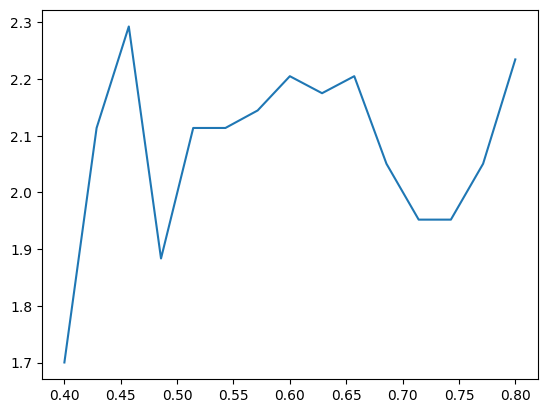

In [7]:
import matplotlib.pyplot as plt

plt.plot(t_vals, y_vals)

In [87]:
t_vals = np.array(t_vals)
def f(x):
   return np.sin(x) + np.cos(x)

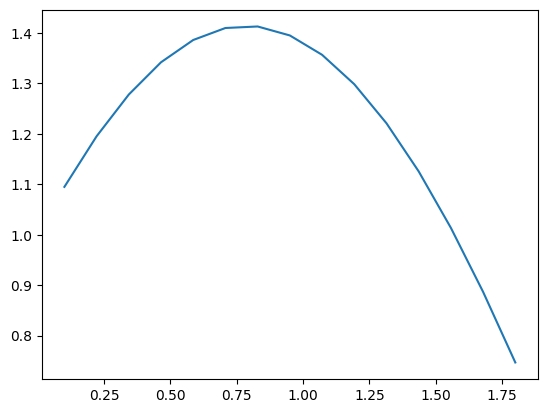

In [89]:
plt.plot(t_vals, f(t_vals))